Discovering basic-level categories
===================

In [120]:
%matplotlib inline

import csv
import gzip
import pickle
from collections import Counter, defaultdict
from math import log, log10
import matplotlib.pyplot as plt
import matplotlib.colors as pltColors
import numpy as np

In [121]:
# Load files
catDescFile = 'data/cat_desc.csv'
catDescHeaders = None
descCatCnt = defaultdict(Counter)
descCnt = Counter()
with open(catDescFile) as fin:
    r = csv.reader(fin)
    for row in r:
        if catDescHeaders is None:
            catDescHeaders = row
            print catDescHeaders
        else:
            descCatCnt[row[1]][int(row[0]) - 1] += int(row[-1])
            descCnt[row[1]] += int(row[-1])

# Load tree model
treeModelFile = 'model/taxoTree_0_0.pickle.gz'
with gzip.open(treeModelFile) as fin:
    treeNodeLst = pickle.load(fin)

['category_id', 'description', 'count']


In [122]:
def JensenShannonDiv(dist1, dist2):
    ans = 0.0
    for k in set(dist1.keys()) | set(dist2.keys()):
        x = dist1[k] if k in dist1 else 0
        y = dist2[k] if k in dist2 else 0
        m = (x + y) * 0.5
        if x > 0:
            ans += x * log(x / m)
        if y > 0:
            ans += y * log(y / m)
    return ans * 0.5

def entropy(dist):
    ans = 0.0
    s = 0.0
    for x in dist.values():
        ans += x * log(x)
        s += x
    if s == 0.0:
        return 0
    else:
        return log(s) - ans / s

In [123]:
# Various statistics
nonleafLst = [i for i, node in enumerate(treeNodeLst) if len(node[2]) > 0]

nodeDepth = [None] * len(treeNodeLst)
nodeHeight = [None] * len(treeNodeLst)
numLeaves = [None] * len(treeNodeLst)
subtreeSize = [None] * len(treeNodeLst)
numSon = [None] * len(treeNodeLst)
numOccur = [None] * len(treeNodeLst)
descEntropy = [None] * len(treeNodeLst)
multualInfo = [None] * len(treeNodeLst)
infoGain = [None] * len(treeNodeLst)
for i in xrange(len(treeNodeLst)):
    name, parent, children = treeNodeLst[i]
    if i == 0:
        nodeDepth[i] = 0
    else:
        nodeDepth[i] = nodeDepth[parent] + 1
    numSon[i] = len(children)
    numOccur[i] = descCnt[name] if len(children) > 0 else 0
    descEntropy[i] = entropy(descCatCnt[name]) if len(children) > 0 else 0
for i in xrange(len(treeNodeLst) - 1, -1, -1):
    name, parent, children = treeNodeLst[i]
    if numSon[i] == 0:
        nodeHeight[i] = 0
        numLeaves[i] = 1
        subtreeSize[i] = 1
    else:
        nodeHeight[i] = 1 + max(nodeHeight[k] for k in children)
        numLeaves[i] = sum(numLeaves[k] for k in children)
        subtreeSize[i] = 1 + sum(subtreeSize[k] for k in children)
        multualInfo[i] = log(numLeaves[i]) - entropy({i:numLeaves[i] for i in children})

print numLeaves[0]
infoGain = [log(numLeaves[0]) - log(numLeaves[i]) for i in xrange(len(treeNodeLst))]

1055


In [124]:
def plotAccumDotPlot(data, dotSize=10, logX=False, logY=False, logCnt=False, figSize=(12, 9)):
    pltDensity = Counter(data)
    pltData = [(x, y, z) for (x, y), z in pltDensity.most_common()]
    pltX, pltY, pltColor = zip(*pltData)
    fig = plt.figure(figsize=figSize)
    ax = fig.add_subplot(1,1,1)
    if logCnt:
        scat = ax.scatter(pltX, pltY, c=pltColor, s=dotSize, edgecolor='', norm=pltColors.LogNorm())
    else:
        scat = ax.scatter(pltX, pltY, c=pltColor, s=dotSize, edgecolor='')
    cbar = fig.colorbar(scat, ax=ax)
    if logX:
        ax.set_xscale('log')
    if logY:
        ax.set_yscale('log')
    plt.show()

def plotHist(data, binNum=50, logX=False, logY=False):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    if logX:
        n, bins, patches = ax.hist(data, bins=np.logspace(0.0, log10(max(data)), binNum))
    else:
        n, bins, patches = ax.hist(data, binNum)
    if logX:
        ax.set_xscale('log')
    if logY:
        ax.set_yscale('log')
    plt.show()

def noLeaf(lst):
    return [lst[i] for i in nonleafLst]

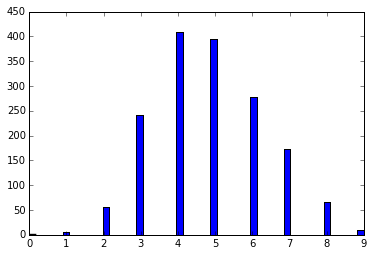

In [125]:
plotHist(nodeDepth)

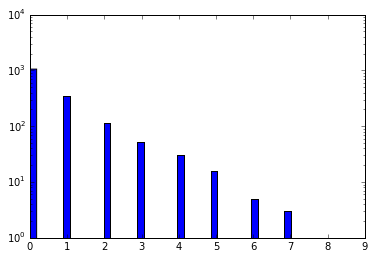

In [126]:
plotHist(nodeHeight, logY=True)

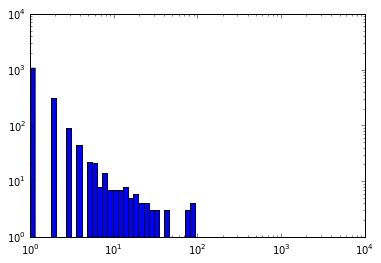

In [127]:
plotHist(numLeaves, logY=True, logX=True)

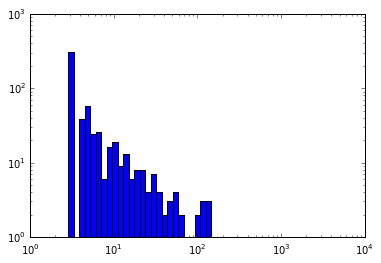

In [128]:
plotHist(noLeaf(subtreeSize), logY=True, logX=True)

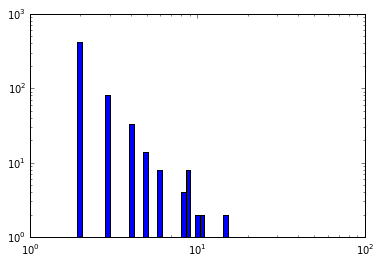

In [129]:
plotHist(noLeaf(numSon), logY=True, logX=True)

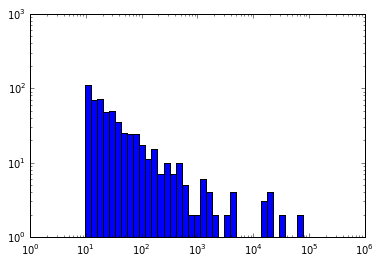

In [130]:
plotHist(noLeaf(numOccur), logY=True, logX=True)

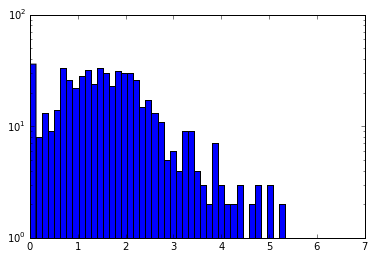

In [131]:
plotHist(noLeaf(descEntropy), logY=True)

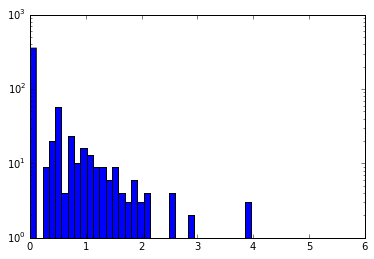

In [132]:
plotHist(noLeaf(multualInfo), logY=True)

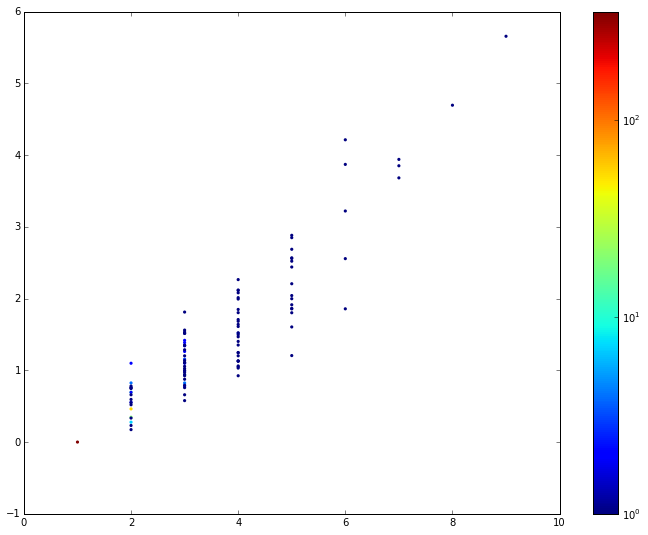

In [133]:
plotAccumDotPlot(noLeaf(zip(nodeHeight, multualInfo)), logCnt=True, logX=False, logY=False)

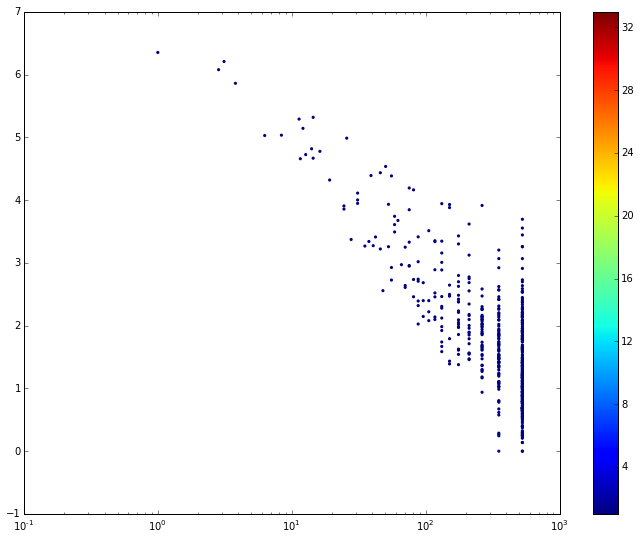

In [134]:
plotAccumDotPlot(noLeaf(zip([1055.0 / x for x in numLeaves], descEntropy)), logCnt=False, logX=True, logY=False)

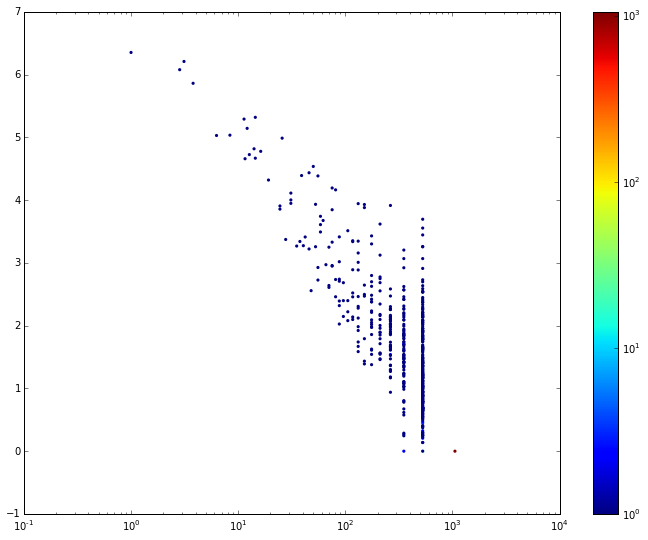

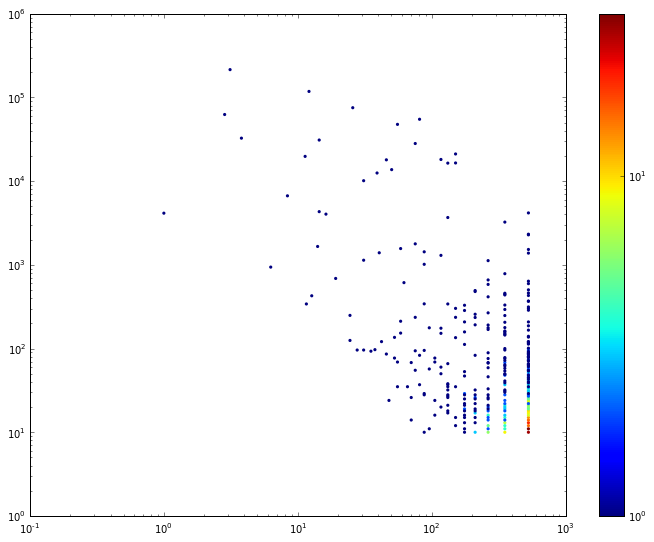

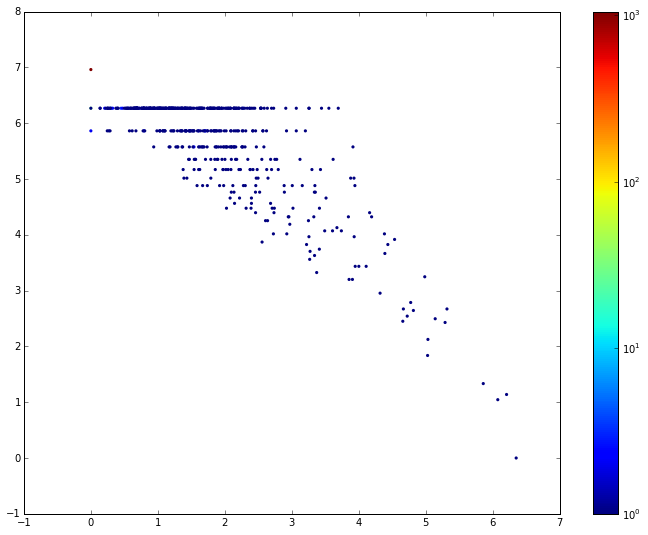

In [135]:
plotAccumDotPlot(zip([1055.0 / x for x in numLeaves], descEntropy), logX=True, logY=False, logCnt=True)
plotAccumDotPlot(noLeaf(zip([1055.0 / x for x in numLeaves], numOccur)), logX=True, logY=True, logCnt=True)
plotAccumDotPlot(zip(descEntropy, infoGain), logY=False, logCnt=True)

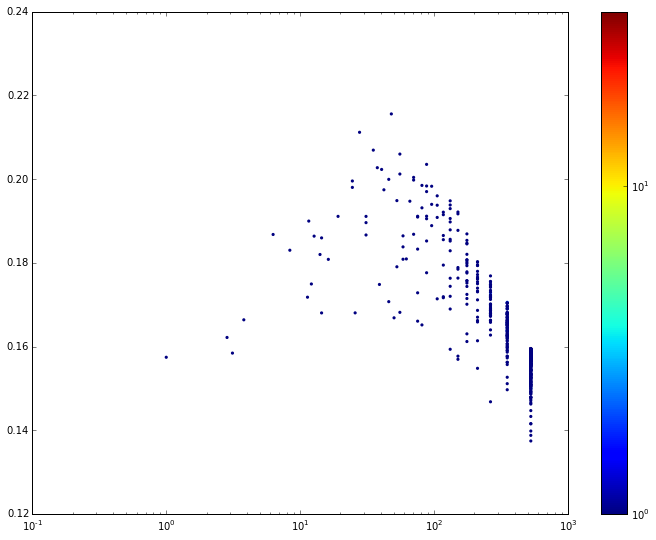

23.1584016687 965 ('subway', 555, (1312, 1313)) 3.69461577352 2 6.26814886535


In [139]:
plotAccumDotPlot(zip([1055.0 / x for x in noLeaf(numLeaves)], [(a**2 + b**2)**-0.5 for a, b in noLeaf(zip(infoGain, descEntropy))]), logX=True, logY=False, logCnt=True)
tmp = [a*b for a, b in noLeaf(zip(infoGain, descEntropy))]
idx = nonleafLst[tmp.index(max(tmp))]
print max(tmp), idx, treeNodeLst[idx], descEntropy[idx], numLeaves[idx], infoGain[idx]

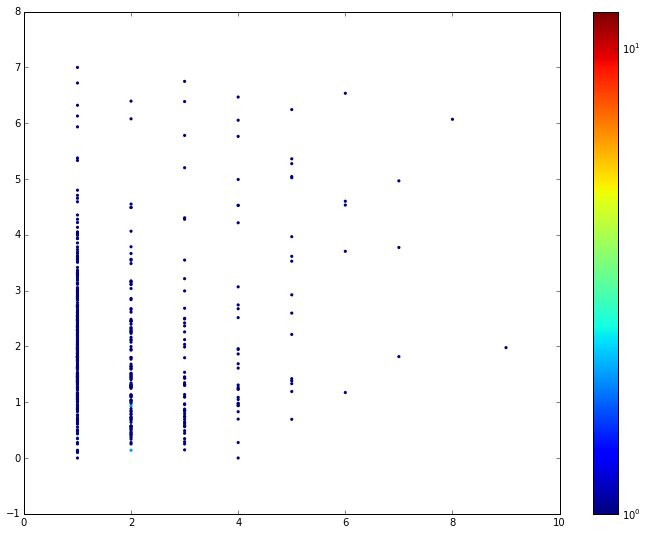

In [137]:
plotAccumDotPlot(zip(noLeaf(nodeHeight), [log(b) - a for a, b in noLeaf(zip(descEntropy, numOccur))]), logX=False, logCnt=True)